# Reinforcement Learning, Q-Tables, and Nim

Andrew Glassner - 15 May 2021, for the SIGGRAPH DL class by Rajesh Sharma

updated 17 June 2021 - Andrew

There's a game that goes by many names - I learned it as **Nim**.
There are lots of variations on Nim out there. This is the simplest
one I know of.

Two players sit facing one another, with a pile of sticks between
them. They're allowed to count the sticks if they like. They
alternate turns. On each turn, a player must remove 1, 2, or 3
sticks from the pile. The goal is to **not** pick up the last stick.
Whoever picks up the final stick loses the game.

It's not a mind-bending exercise to figure out the best strategy,
but try to resist that urge for the moment. 

## Setup

Bring in the libraries. We won't need any deep learning for this,
just Numpy for random numbers and some basic math, and matplotlib
to draw graphics. We'll also use seaborn, a package that makes the standard matplotlib graphics look a bit prettier.

We don't need the GPU, so Colab's default setting of CPU-only is fine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3) # scale up the default graph font size

## A few global variables

A few things that will control our game and simulations.

In [2]:
smallest_starting_pile = 4  # Must be >=4 so nobody loses instantly
largest_starting_pile = 60  
games_played_for_big_plots = 500

# Just to get going, play randomly

Let's write a bare-bones routine to play a single round randomly. We'll start with a pile of random size, and the agent and computer will alternate, with the first player chosen at random. Each player randomly picks 1, 2, or 3 sticks for their move. Who will win most often? Let's find out!

In [3]:
# Returns True if we won this round

def play_one_round_randomly():
 
    pile_size = np.random.randint(smallest_starting_pile, largest_starting_pile+1)
    agent_plays_first = np.random.randint(0, 2) < 1
    
    # Our main loop starts with the person's move, so if the computer
    # is going first this time, handle that before the loop
    if not agent_plays_first:
        num_sticks = np.random.randint(1, 4)
        pile_size -= num_sticks
        
    # The main loop. We pick a random number of sticks to remove. If we
    # picked the last stick, we lose. Else the computer goes. If it picks
    # the last stick, then it loses. And around the loop we go. Return
    # True if we win the game, else False.
    while pile_size > 0:
        
        # Agent's move
        num_sticks = np.random.randint(1, 4)
        
        num_sticks = min(num_sticks, pile_size)  # Don't try to take more than there are
        pile_size -= num_sticks
        if pile_size < 1:
            return False # Drat, we just picked up the last stick
        
        # Computer's move
        num_sticks = np.random.randint(1, 4)
        num_sticks = min(num_sticks, pile_size)  
        pile_size -= num_sticks
        if pile_size < 1:
            return True # Hah! The computer picked up the last stick!

In [4]:
# Let's play many rounds, and collect the winner from each

results = []
for i in range(games_played_for_big_plots):
    victory = play_one_round_randomly()
    results.append(victory)

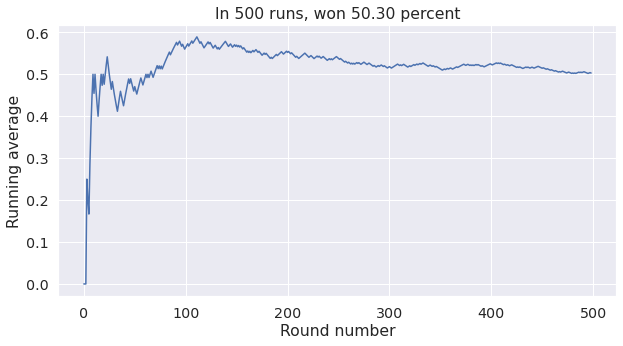

In [5]:
# Plot the running average of how often we won

running_average = [np.sum(results[:i])/i for i in range(1, len(results))]

fig = plt.figure(figsize=(10,5))
plt.plot(running_average)
plt.xlabel('Round number')
plt.ylabel('Running average')
plt.title('In {:d} runs, won {:0.2f} percent'.format(len(results), 100*running_average[-1]))
plt.show()

## Discussion

No surprise there. In a completely random game, we win about half of the time.

This game is simple enough that we can do much better. Let's use 
reinforcement learning to enable the agent to learn how to win.

Side note: We didn't really have to deal with who went first. If the computer
went first, since it made a random move, we ended up just subtracting one
random number from another. We could have skipped all that logic and just started
with the agent every time. But I liked showing the process explicitly. 

Once the agent and the computer both get better at the game, moving first will
become a distinct advantage. To clearly see how we're improving our players,
from now on the agent will always get the first move.

# Using Reinforcement Learning

In reinforcement learning (RL), we break the world up into two pieces: the **agent** who is about to take an action, and the **environment** which is everything in the world except the agent. In a two-player game, each player takes a turn being the agent, so that the other player becomes part of the environment during that time.

In this simple scenario, we'll imagine that our agent is trying to learn to play, and its opponent is embedded in the environment.

In my book [Deep Learning: A Visual Approach](https://nostarch.com/deep-learning-visual-approach), I break down each move in a game like this into six steps (Figure 21-2, page 604). 

1. Environment sends the current board to the agent
2. Environment sends possible moves to the agent
3. Agent picks a move and sends it to the environment
4. Environment receives that choice
5. Environment applies the move, checks for victory, and computes a reward. If the game wasn't won, make a reply move, and check for victory. If computer just won, adjust the reward.
6. Environment sends the reward to the agent

In this scenario, we'll hard-wire step 2 into the code, since the rules of the 
game tell us the only legal moves are to take 1, 2, or 3 sticks.

So we have two tasks. First, create an environment that can take care of all the jobs above. Then, create an agent that will learn to play the game against the computer
embedded in that environment.

## Define the environment

The `Environment` class holds the pile of sticks (that is, it models
the whole world). 

In [6]:
class Environment:
    
    def __init__(self, computer_player):
        self.computer_player = computer_player
        self.new_game()
        
    def new_game(self):
        self.pile_size = np.random.randint(smallest_starting_pile, largest_starting_pile+1)
        self.moves_list = []
        self.game_over = False
        
    def get_pile_size(self):
        return self.pile_size
        
    def print_pile_size(self):
        print('The pile holds {} sticks'.format(self.pile_size))
        
    def apply_move(self, num_sticks):
        self.pile_size -= num_sticks
        self.moves_list.append(num_sticks)
        return self.check_for_game_over()
            
    def apply_computer_move(self):
        num_sticks = self.computer_player.make_move(self.pile_size)
        game_over = self.apply_move(num_sticks)
        return game_over

    def apply_agent_move(self, num_sticks):
        game_over = self.apply_move(num_sticks)
        return game_over

    def check_for_game_over(self):
        return self.pile_size < 1

## The RL loop

Now let's write the basic RL loop for playing one game. 
We'll get a move from the player, 
apply it, and compute a reward. If the player just won, we're for
that game. Otherwise, the computer makes a move. If it wins, we
adjust the reward. Then we send the reward to the agent. If the 
game isn't over, we go back to the top and repeat.

I'll include lots of (optional) print statements in this
loop, so by setting `verbose` to `True`, 
we can watch individual runs and see every move.
When we make big simulations, we'll leave `verbose` at 
its default of `False` so we don't type out endless text!

In [7]:
def RL_loop(env, computer_player, agent, verbose=False):
    if verbose:
        print('starting with',env.get_pile_size(),'sticks in the pile')
    while not env.check_for_game_over():
        agent_move = agent.make_move(env.get_pile_size())
        game_over = env.apply_agent_move(agent_move)
        if verbose:
            print('agent took',agent_move,'sticks, leaving ',env.get_pile_size())
        if game_over:
            agent.process_reward(0, 0)  # We lost, so reward is 0
            if verbose:
                print('--- Computer wins.')
            return 0
        game_over = env.apply_computer_move()
        if verbose:
            print('computer played and left',env.get_pile_size(),'sticks')
        if game_over:
            agent.process_reward(1, 0)  # Computer lost = we won!
            if verbose:
                print('+++ Agent wins!')
            return 1
        if verbose:
            print('round complete, pile size =',env.get_pile_size())
        agent.process_reward(0, env.get_pile_size())

## A naive computer player

This is a naive computer player. It picks 1, 2, or 3 sticks at random,
but at least it makes sure it doesn't take more sticks than there are.

In [8]:
class Naive_computer_player:
    
    def __init__(self):
        pass # nothing to initialize, but keep a placeholder for someday
    
    def new_game(self):
        pass # nothing for now
        
    def make_move(self, pile_size):
        num_sticks = np.random.randint(1, 4)     # randomly pick 1, 2, or 3 sticks
        num_sticks = min(pile_size, num_sticks)  # Don't try to take more than there are
        return num_sticks

## A naive agent

This is the move naive agent - it's the same as the naive computer player. It has one more
method, `process_reward()` to handle the reward that the environment sends (along with
the size of the new pile, after the computer got to move), but we won't do anything
with that information for now.

In [9]:
class Naive_agent:
    
    def __init__(self):
        pass # nothing to initialize, but keep a placeholder for someday
    
    def new_game(self):
        pass # nothing now
        
    def make_move(self, pile_size):
        num_sticks = np.random.randint(1, 4)     # randomly pick 1, 2, or 3 sticks
        num_sticks = min(pile_size, num_sticks)  # Don't try to take more than there are
        return num_sticks
    
    def process_reward(self, reward, new_pile_size):
        pass # We won't do anything with the reward

## Utilities

In [10]:
# A little utility to run lots of games and plot our running average of victories

def show_games(env, computer_player, agent, num_rounds, verbose=False):
    results = []

    for i in range(num_rounds):
        computer_player.new_game()
        agent.new_game()
        env.new_game()
        agent_victory = RL_loop(env, computer_player, agent, verbose=False)
        results.append(agent_victory)

    running_average = [np.sum(results[:i])/i for i in range(1, num_rounds)]

    fig = plt.figure(figsize=(10,5))
    plt.plot(running_average)
    plt.xlabel('Round number')
    plt.ylabel('Running average')
    plt.title('In {:d} runs, won {:0.2f} percent'.format(num_rounds, 100*running_average[-1]))
    plt.show()

In [11]:
# A little utility to show a table of numbers as a heatmap

def show_heatmap(heatmap):
    fig = plt.figure(figsize=(10, 3))
    ax = sns.heatmap(np.transpose(heatmap), linewidth=0.01, cmap='cool')
    ax.set_yticklabels([1+v for v in range(heatmap.shape[1])], rotation= 0)
    ax.tick_params(left=False, bottom=False) # turn off the little tick marks
    plt.title('min={:0.3f}, max={:0.3f}'.format(np.min(heatmap), np.max(heatmap)))
    plt.show()

# Give it a go

If we got all of the pieces in there correctly, we should be able to
replicate our earlier experiment of a random agent versus a
random computer, and win about 50% of the time.

In [12]:
# Let's play one game and watch it happen

np.random.seed(43)
computer_player = Naive_computer_player()
agent = Naive_agent()
env = Environment(computer_player)

agent_reward = RL_loop(env, computer_player, agent, verbose=True)
print('agent reward =',agent_reward)

starting with 8 sticks in the pile
agent took 1 sticks, leaving  7
computer played and left 5 sticks
round complete, pile size = 5
agent took 2 sticks, leaving  3
computer played and left 0 sticks
+++ Agent wins!
agent reward = 1


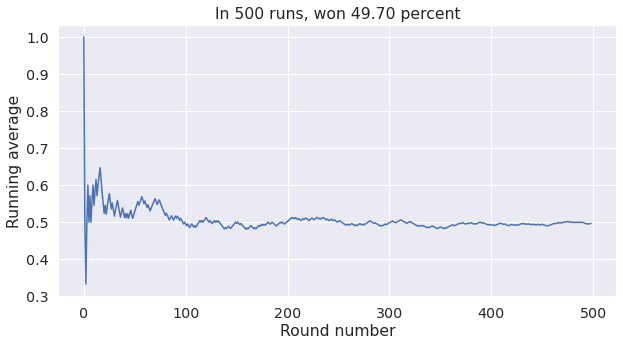

In [13]:
# Play lots of games and plot the running average

np.random.seed(43)

computer_player = Naive_computer_player()
agent = Naive_agent()
env = Environment(computer_player)

show_games(env, computer_player, agent, 
           num_rounds=games_played_for_big_plots, verbose=False)

## Discussion

Great, it looks like everything's working properly. With both the
agent and the computer playing randomly, we each win about half the
time.

## Making a smarter agent

Now that we have the pieces in place, we can focus just on the agent.
We'll keep track of our rewards in a "Q-table" (the Q stands for "quality" - really!).
The table has one row for each configuration of the environment. For us, that
means there's one row for each possible number of sticks in the pile.
There is one column for each possible action we can take.

To keep things simple, we'll recognize that we have only three possible
moves. So our table will have as many rows as
the global `largest_starting_pile` defined up top,
and it will have
3 columns (one for each possible move). We'll initially
fill it up with 0's.

This table will tell us the expected reward we'll get if we play that
move for that number of sticks (though the random computer player means
that this reward isn't guaranteed).

We'll make things more interesting later, but let's start simple.
When it's time to pick a move, we'll consult the table for that row. If
there's an entry bigger than the others, we'll be greedy and pick it.
Otherwise, we'll pick an entry at random.

When the game is over, we'll put the final reward in every move that we
played throughout the game.

In [14]:
class Smart_agent_1:
    
    def __init__(self):
        self.Q_table = np.zeros((largest_starting_pile+1, 3))
        self.played_moves = []
        
    def new_game(self):
        self.played_moves = []
        
    def make_move(self, pile_size):
        target_row = self.Q_table[pile_size]
        if max(target_row) == 0:
            # pick a random entry
            self.action_number = np.random.randint(0, 3)
        else:
            # pick largest entry
            self.action_number = np.argmax(target_row)
            
        num_sticks = self.action_number+1
        self.played_moves.append([pile_size, self.action_number, num_sticks])
                    
        num_sticks = min(pile_size, num_sticks)  # Don't try to take more than there are
        return num_sticks
    
    def process_reward(self, reward, new_pile_size):
        # A terrible way to update the Q-table is to simply write the
        # new reward into every cell that led to success. We ignore
        # the new_pile_size.
        for move in self.played_moves:
            move_pile_size, move_action_number, move_num_sticks = move
            self.Q_table[move_pile_size][move_action_number] = reward

In [15]:
# Let's play one game and watch it happen

np.random.seed(45)

computer_player = Naive_computer_player()
agent = Smart_agent_1()
env = Environment(computer_player)

agent_reward = RL_loop(env, computer_player, agent, verbose=True)
print('agent reward =',agent_reward)

starting with 15 sticks in the pile
agent took 3 sticks, leaving  12
computer played and left 11 sticks
round complete, pile size = 11
agent took 1 sticks, leaving  10
computer played and left 8 sticks
round complete, pile size = 8
agent took 2 sticks, leaving  6
computer played and left 5 sticks
round complete, pile size = 5
agent took 2 sticks, leaving  3
computer played and left 2 sticks
round complete, pile size = 2
agent took 2 sticks, leaving  0
--- Computer wins.
agent reward = 0


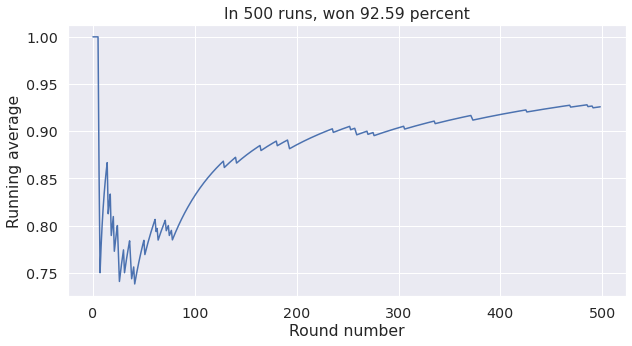

In [16]:
# Play lots of games and plot the running average

np.random.seed(42)

computer_player = Naive_computer_player()
agent = Smart_agent_1()
env = Environment(computer_player)

show_games(env, computer_player, agent,
           num_rounds=games_played_for_big_plots, verbose=False)

## Discussion

The agent is doing fabulously! Why? Let's look at the Q-table for a clue.

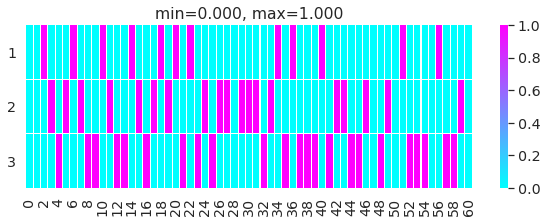

In [17]:
show_heatmap(agent.Q_table)

## Discussion

This visualization rotates the Q-table onto its side, so it fits the
notebook better. So each column corresponds to the number of sticks
in the pile that the agent is looking at, and each row corresponds
to the Q-value associated with taking 1, 2, or 3 sticks.

At the far left it looks like there's a little pattern going on, but it looks more or less random for piles of size 12 or more (since we're using random numbers, you might find
the pattern dissolving at a different point). 

Getting ahead of ourselves, we can say that the pattern at the left
shows that the agent learned how to win when the piles were small. 
But when the piles were large, it basically made random moves.

The agent was able to win some pile sizes consistently
because the computer played randomly. So as the pile got smaller, 
the agent was able to steer the computer into a losing position,
since the computer wasn't doing anything defensive to prevent that.

Winning against an opponent who doesn't know the rules of the game 
or how to win (or avoid losing) isn't much of a challenge. 
Let's make the computer smarter, and see how well our agent fares.

## A smart computer player

Let's make the computer smarter and let it play the winning strategy
whenever it can.

If you don't already know how to win at Nim, I suggest you think about
it for a bit and come up with the rule yourself. It's fun!

**Spoiler: Here's how to win.** Always leave the
other player with $1+4n$ sticks, where $n$ is any integer. 
If you can't (because that's how many
you have now), pick something random and hope the other player makes
a mistake. If they don't make a mistake (because they know the
rule, too, and will try to leave *you* with $1+4n$ sticks), you'll lose.

In [18]:
class Smart_computer_player:
    
    def __init__(self):
        pass # nothing to initialize, but keep a placeholder for someday
    
    def new_game(self):
        pass # nothing for now
        
    def make_move(self, pile_size):
        num_sticks = (pile_size - 1) % 4
        if num_sticks == 0:
            num_sticks = np.random.randint(1, 4)     # randomly pick 1, 2, or 3 sticks
        num_sticks = min(pile_size, num_sticks)  # Don't try to take more than there are
        return num_sticks

In [19]:
# Play one game and watch how it goes

np.random.seed(46)

computer_player = Smart_computer_player()
agent = Smart_agent_1()
env = Environment(computer_player)

agent_reward = RL_loop(env, computer_player, agent, verbose=True)
print('agent reward =',agent_reward)

starting with 9 sticks in the pile
agent took 1 sticks, leaving  8
computer played and left 5 sticks
round complete, pile size = 5
agent took 1 sticks, leaving  4
computer played and left 1 sticks
round complete, pile size = 1
agent took 1 sticks, leaving  0
--- Computer wins.
agent reward = 0


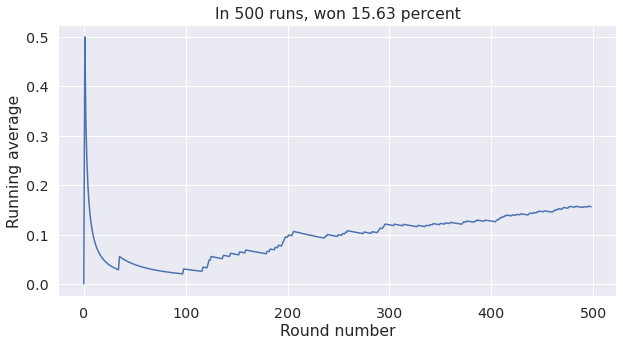

In [20]:
# Play lots of games and plot the running average

np.random.seed(41)

computer_player = Smart_computer_player()
agent = Smart_agent_1()
env = Environment(computer_player)

results = show_games(env, computer_player, agent,
           num_rounds=games_played_for_big_plots, verbose=False)

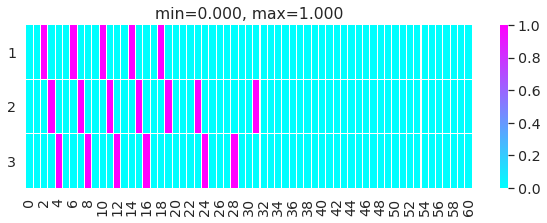

In [21]:
show_heatmap(agent.Q_table)

# Discussion

Wow. The computer is dominating.
It never makes a mistake. And in those
times when it doesn't have a winning situation, it's not
uncommon for the agent to make a mistake, and the computer
can recover. 

There's a pattern showing up for the agent. It appears that
the agent is learning, but slowly. Because the computer never
makes a mistake, there are very few opportunities for the
agent to learn. If the agent starts with a large pile, it's
more than likely to make a wrong move.
In short,
our agent is going to need to be smarter than just 
remembering how it earns victories, because
those victories are rare.

If we let this run for a *long* time, the agent will 
slowly improve. But that cost is going to add up 
fast for situations more complicated than this little game,
and it could make this whole approach impractical.

We need to improve the agent.



## Making a better agent

So
instead of over-writing the value in the table, we'll update it. And
instead of working our way through all of the moves, we'll apply this
update to just the current move.

We will do three new things, each controlled by a floating-point number
that usually goes by a Greek letter:

1. When it's time to pick a move, we find the best move in that row
of the table, as before. We then draw a random uniform value from
$[0, 1]$. If it's greater than $\epsilon$ (epsilon), then we'll stick
with the value we have, or we **exploit** what we've learned. If the
value is less than $\epsilon$, we'll pick a different entry at random,
or we **explore** other moves and see what happens.

2. We look up the best Q-value for the new state (that is, we assume
we're going to exploit for our next action, and not explore. We can remove
that assumption with some more book-keeping - that method is called SARSA).
Since we can't be certain we'll end up in that state every time (the
computer might make a mistake), we'll **discount** it (that is, make
it smaller) by multiplying it by $\gamma$ (gamma), usually around 0.9.

3. We'll add the reward to the discounted new Q-value from step 2, and
then **blend** that with the Q-value for the move we just made. The
new value will be found by linear blending from the old value to the
new using $\alpha$ (alpha), usually around 0.95. That means we'll use
95% of the new value, and 5% of the old. That becomes the new Q-value
for that move.

You can find a full discussion of why these methods work, along with
lots of figures illustrating what's going on, in Chapter 21 of my book.
Notebooks can't contain remote figures, so click
[Q-Learning Figure](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/21-29.png) to see a high-res illustration.

In the book,
you can also see these methods applied to a slightly more interesting 
solitaire game where we try flipping over tiles to make a single
row or column of dots.

In [22]:
class Smart_agent_2:
    
    def __init__(self, alpha=0.95, epsilon=0.01, gamma=0.9):
        self.Q_table = np.zeros((largest_starting_pile+1, 3))
        self.played_moves = []
        self.alpha = alpha  # blend factor for new results
        self.epsilon = epsilon # percent of time we explore rather than exploit
        self.gamma = gamma # discount factor on next move
        
    def new_game(self):
        self.played_moves = []
        
    def make_move(self, pile_size):
        target_row = self.Q_table[pile_size]
        if max(target_row) == 0:
            # pick a random entry
            self.action_number = np.random.randint(0, 3)
        else:
            chosen_action = np.argmax(target_row)
            # should we explore rather than exploit?
            explore = np.random.uniform() < self.epsilon
            if explore:
                choices = [0, 1, 2]
                choices.remove(chosen_action)
                chosen_action = np.random.choice(choices)
                
            self.action_number = chosen_action
            
        num_sticks = self.action_number+1
        self.played_moves.append([pile_size, self.action_number, num_sticks])
                    
        num_sticks = min(pile_size, num_sticks)  # Don't try to take more than there are
        return num_sticks
    
    def process_reward(self, reward, new_pile_size):
        # Get the information for the move we just made
        move = self.played_moves[-1]
        move_pile_size, move_action_number, move_num_sticks = move
        old_Q_value = self.Q_table[move_pile_size][move_action_number]
        
        # Now find the best Q-value in the new state
        best_next_action = np.argmax(self.Q_table[new_pile_size])
        new_Q_value = self.Q_table[new_pile_size][best_next_action]
        
        # Discount the new Q-value because we can't be sure we'll always get it
        new_Q_value *= self.gamma

        # Add in the new reward
        new_Q_value += reward

        # Blend with old value
        updated_Q_value = (self.alpha * new_Q_value) + \
                         ((1-self.alpha) * old_Q_value)
        # And save it
        self.Q_table[move_pile_size][move_action_number] = updated_Q_value

In [23]:
# Play one game and see what happens

np.random.seed(31)

computer_player = Smart_computer_player()
agent = Smart_agent_2()
env = Environment(computer_player)

agent_reward = RL_loop(env, computer_player, agent, verbose=True)
print('agent reward =',agent_reward)

starting with 22 sticks in the pile
agent took 1 sticks, leaving  21
computer played and left 18 sticks
round complete, pile size = 18
agent took 3 sticks, leaving  15
computer played and left 13 sticks
round complete, pile size = 13
agent took 3 sticks, leaving  10
computer played and left 9 sticks
round complete, pile size = 9
agent took 1 sticks, leaving  8
computer played and left 5 sticks
round complete, pile size = 5
agent took 1 sticks, leaving  4
computer played and left 1 sticks
round complete, pile size = 1
agent took 1 sticks, leaving  0
--- Computer wins.
agent reward = 0


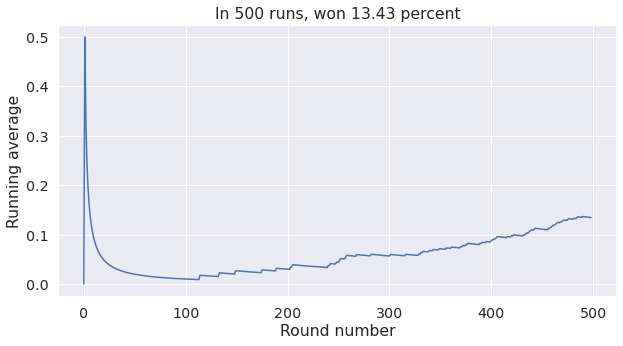

In [24]:
# Play lots of games and plot the running average

np.random.seed(41)

computer_player = Smart_computer_player()
agent = Smart_agent_2()
env = Environment(computer_player)

results = show_games(env, computer_player, agent,
           num_rounds=games_played_for_big_plots, verbose=False)

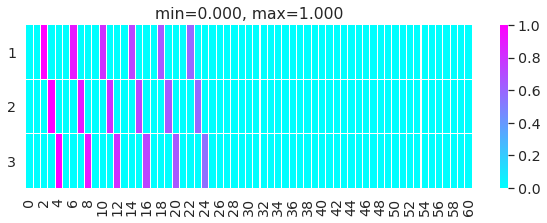

In [25]:
show_heatmap(agent.Q_table)

## Discussion

That's encouraging. The agent is definitely learning more quickly
(again, due to random numbers, your plots may differ a little).
But it's not doing great, and it hasn't learned anything at all
about how to handle large starting piles.

What's going wrong?

Nothing! The running average curve is still climbing.
And the Q-table shows that the agent is learning the pattern
perfectly. It's extra nice that it's discovered that when
it has a losing pile, when playing against the computer,
it cannot win: no choice of move is a good move.

How do we help our agent get smarter?
Play more games!
Remember that the Q-table is growing left to right 
(in the figure, we can see that the moves with the highest
values are at the left, and the quality decreases as we
move to the right).
To extend the table farther to the right,
we just need to play more games,
so the agent can learn
how to make the right move when the piles are large. 

We just need to train some more. Let's try again, but with many
more games.

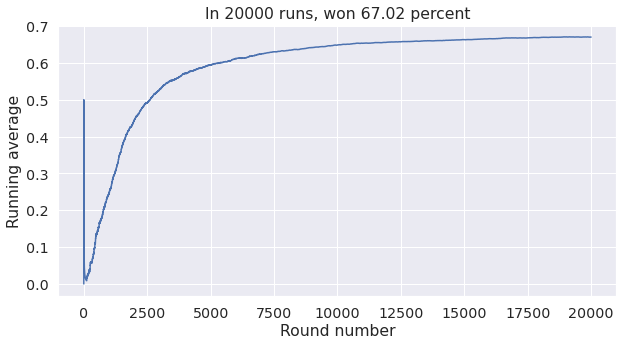

In [26]:
# Play very many more games and plot the running average.
# This might take a couple of minutes.

np.random.seed(41)

computer_player = Smart_computer_player()
agent = Smart_agent_2()
env = Environment(computer_player)

results = show_games(env, computer_player, agent,
           num_rounds=40*games_played_for_big_plots, verbose=False)

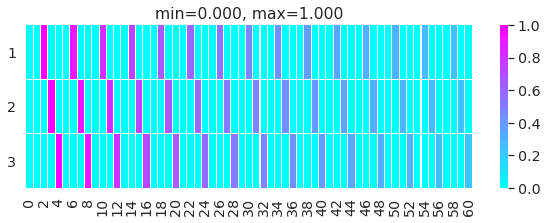

In [27]:
show_heatmap(agent.Q_table)

## Discussion

That's more like it. The cells are still decreasing in confidence
as we work our way to the right, but at least we have a good
starting move for every pile. That's all we need to play a
perfect game, since this Q-table will never make a mistake.
It will lose when it starts with a losing pile size, but
otherwise, even against a perfect opponent, it will always
win, because the agent always gets to play first.

Well, not quite.
The agent can lose from a winning position if it decides
to explore rather than exploit.
We could replace our simple rule based on the
value of $\epsilon$ with something more sophisticated
that says, in essence,
after you've explored enough alternatives,
and the current best choice is almost always (or even always)
the best choice,
stop exploring and just exploit
(that is, always use the best value for that number of sticks).

Actually,
we can do that right away,
because our reward values were only 0 or 1. 
We did this for simplicity,
but it's not realistic.
Typically, rewards will be
floating-point values that span a range.
For example, if we're using reinforcement learning to manage
elevators in a building, then the reward can be based on the
average amount of time that people need to wait, with larger
rewards corresponding to smaller average waits.

But since we're using only 0 and 1, we can set the exploration
probability $\epsilon$ to 0, meaning that the
agent will only exploit moves it found that led to victory.
That brings our success up to about the 75% we would expect,
since out of any group of four sequential pile sizes
(such as 8, 9, 10, 11), the agent should
win three of them.
Since our pile sizes are being selected randomly,
we'd expect the running average to close in on 0.75
and perhaps wiggle up and down around it.

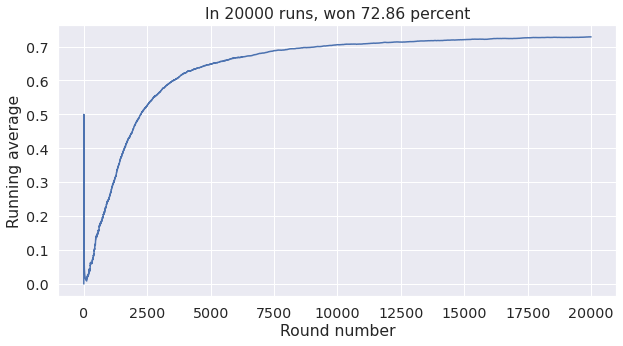

In [28]:
# Play very many more games and plot the running average.
# This might take a couple of minutes.

np.random.seed(41)

computer_player = Smart_computer_player()
agent = Smart_agent_2(epsilon=0)  # Never explore if there's a non-zero move
env = Environment(computer_player)

results = show_games(env, computer_player, agent,
           num_rounds=40*games_played_for_big_plots, verbose=False)

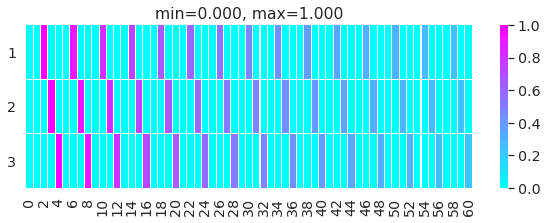

In [29]:
show_heatmap(agent.Q_table)

## Discussion


A problem with Q-learning is that it doesn't scale up very nicely.
Consider a game of tic-tac-toe: what could be simpler?
Instead of a 3-by-3 board, we'll play on a 15-by-15 board.
That seems big, but hardly outrageous. But the Q-table for
that game would need $3^{15\times 15} \sim 10^{82}$
cells, which is more cells that there are atoms in the
visible universe! It's roughly the number of atoms in a
*billion* universes - and that doesn't even include the
space needed to store the data!

A popular fix for this problem is to
replace the Q-table with a neural network that learns the
contents of the table, and can *predict*
the value for any 
cell without explicitly storing the table. 
This is called **Deep Q-learning** or 
**Deep reinforcement learning**, and it's one of the
techniques behind many of the famous reinforcement learning
headlines of the recent past, such as Deep Mind's program
*AlphaZero*, which is arguably the best player of the game
of *Go* that has ever existed.
